## Lecture 2: Accelerating Python Code

### OSM Bootcamp 2018

#### John Stachurski

In this notebook I'm going to discuss how to accelerate Python code in scentific applications.  

I'll focus on two methods: vectorization and JIT compilation.

By "vectorization" I mean working with arrays and matrices to speed up scientific computing. This is a neat trick that was pioneered by MATLAB.  The basic idea is that, with vectorized code, the overheads associated with running interpreted high level code are paid *per array* rather than per scalar operation.  With large arrays, that saves a lot of overhead.

But vectorization is, in the end, a hack, and it has costs as well as benefits.  

Fortunately, we have another alternative for accellerating code written in a high level language that is becoming increasing popular: just-in-time (JIT) compilation.  Even better, we have a JIT compiler for Python that's directly aimed at scientific computing and, while still young, developing rapidly into an extremely useful package.

**TL;DR** Vectorization is neat but JIT compilation is better.  This notebook explores the key ideas using Python and Numba --- in my view the best package for modern scientific computing.



In [26]:
import numpy as np
from numba import vectorize, jit, njit, float64, prange
import matplotlib.pyplot as plt

### Vectorization

In scripting languages, native loops are slow:

In [27]:
n = 1_000_000
r_vec = np.random.randn(n)

In [28]:
%%time

current_max = - np.Inf
for x in r_vec:
    if x > current_max:
        current_max = x


CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 132 ms


Python's built in `max` function is a little faster but not much:

In [29]:
%%time

max(r_vec)


CPU times: user 90 ms, sys: 0 ns, total: 90 ms
Wall time: 92.2 ms


4.843007427970043

The reason is that Python, like most high level languages is dynamically typed.

This means that the type of a variable can change at any time.

So the interpreter has to check the type of variables before any operation like addition, comparison, etc.

Hence there's a lot of fixed cost for each such operation

The code runs much faster if we use **vectorized** expressions to avoid explicit loops.

In [30]:
%%time 

np.max(r_vec)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 761 µs


4.843007427970043

It's the same if we use the equivalent method --- since we're calling into the same compiled code.

In [31]:
%%time

r_vec.max()


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 736 µs


4.843007427970043

Now high level overheads are paid per *array* rather than per float or integer.

Another example: To compute the sum of of $\cos(2\pi / x)$ over $x$ in 

In [32]:
x_vec = np.linspace(0.1, 1.1, n)

loops are slow...

In [33]:
%%time

current_sum = 0.0
for x in x_vec:
    current_sum += np.cos(2 * np.pi / x)

CPU times: user 2.12 s, sys: 3.33 ms, total: 2.12 s
Wall time: 2.12 s


but vectorized code is fast:

In [34]:
%%time

np.sum(np.cos(2 * np.pi / x_vec))


CPU times: user 26.7 ms, sys: 0 ns, total: 26.7 ms
Wall time: 25.1 ms


135249.4192778737

#### Implict Multithreading

Recent versions of Anaconda are compiled with Intel MKL support, which accelerates NumPy operations.

Watch system resources when you run this code.  

(For example, install `htop` (Linux / Mac), `perfmon` (Windows) or another system load monitor and set it running in another window.)

In [35]:
n = 20
m = 1000
for i in range(n):
    X = np.random.randn(m, m)
    λ = np.linalg.eigvals(X)

You should see all your cores light up (but perhaps not all your "CPUs", depending on your hardware).  With MKL, many matrix operations are automatically parallelized.

### Problems with Vectorization

Vectorization is neat but there are significant problems

1. Loops are more flexible (some algorithms can't be vectorized)
2. Memory intensive (see below)

### Numba

Recently something fun has come on the scene: fast, efficient just-in-time compilation within Python.  For numerical Python, the best JIT engine is Numba.

Consider the time series model

$$ x_{t+1} = \alpha x_t (1 - x_t) $$

Let's set $\alpha = 4$

In [36]:
α = 4.0

Here's a typical time series:

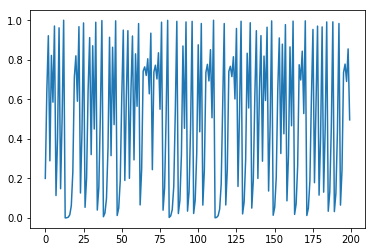

In [37]:
n = 200
x =  np.empty(n)
x[0] = 0.2
for t in range(n-1):
    x[t+1] = α * x[t] * (1 - x[t])
    
plt.plot(x)
plt.show()

Here's a function that simulates for `n` periods, starting from `x0`, and returns **only the final** value:

In [38]:
def quad(x0, n):
    x = x0
    for i in range(1, n):
        x = α * x * (1 - x)
    return x

Let's see how fast this runs:

In [39]:
n = 10_000_000

In [40]:
%%time

x = quad(0.2, n)

CPU times: user 837 ms, sys: 0 ns, total: 837 ms
Wall time: 838 ms


Now let's try this in FORTRAN.  In the following code, all parameters are the same as for the Python code above.

In [41]:
%%file fastquad.f90

PURE FUNCTION QUAD(X0, N)
 IMPLICIT NONE
 INTEGER, PARAMETER :: DP=KIND(0.d0)                           
 REAL(dp), INTENT(IN) :: X0
 REAL(dp) :: QUAD
 INTEGER :: I
 INTEGER, INTENT(IN) :: N
 QUAD = X0
 DO I = 1, N - 1                                                
  QUAD = 4.0_dp * QUAD * real(1.0_dp - QUAD, dp)
 END DO
 RETURN
END FUNCTION QUAD

PROGRAM MAIN
 IMPLICIT NONE
 INTEGER, PARAMETER :: DP=KIND(0.d0)                          
 REAL(dp) :: START, FINISH, X, QUAD
 INTEGER :: N
 N = 10000000
 X = QUAD(0.2_dp, 10)
 CALL CPU_TIME(START)
 X = QUAD(0.2_dp, N)
 CALL CPU_TIME(FINISH)
 PRINT *,'last val = ', X
 PRINT *,'elapsed time = ', FINISH-START
END PROGRAM MAIN

Overwriting fastquad.f90


**Note** The next step will only execute if you have a FORTRAN compiler installed and modify the compilation code below appropriately.

If you don't then skip execution of the next two cells --- you can just look at my numbers.

In [42]:
!gfortran -O3 fastquad.f90

/usr/bin/sh: gfortran: command not found


In [43]:
!./a.out

/usr/bin/sh: ./a.out: No such file or directory


Now let's do the same thing in Python using Numba's JIT compilation.  First we target the function for JIT compilation:

In [44]:
quad_jitted = jit(quad)

Now let's call it:

In [45]:
%%time

x = quad_jitted(0.2, n)


CPU times: user 96.7 ms, sys: 3.33 ms, total: 100 ms
Wall time: 98.3 ms


In [46]:
%%time

x = quad_jitted(0.2, n)


CPU times: user 46.7 ms, sys: 0 ns, total: 46.7 ms
Wall time: 48.2 ms


After JIT compilation, function execution speed is about the same as Fortran.

Thus, in the sense of serial execution, it's running as fast as it can go.

The second call is faster than the first because there's no hold up for compilation --- the compiled instructions now live in RAM and, in the second instance, the call is dispatched to this precompiled code.

Note, however, that if you were to call the function with arguments such that their types are no longer the same as the types of the previous calls, then the compiler will generate a new set of machine code, and store it in memory along with the first.  Subsequent calls will be dispatched to the right code by Numba.

#### Decorator Syntax

By the way, a more common way to target a function for JIT compilation is to use a decorator, like so:

In [47]:
@jit
def f(x):
    return 2 * x

You can also use `@njit` or, equivalently, `@jit(nopython=True)` to force an error if the JIT compiler is unable to compile your code efficiently (in particular, if it has to fall back to object mode):

In [48]:
@njit
def f(x):
    return 2 * x

#### How does it work?

The secret sauce is type inference inside the function body.

When we call `quad_jitted` with particular arguments, Numba's compiler works through the function body and infers the types of the variables inside the function.

It then produces compiled code *specialized to that type signature*

For example, we called `quad_jitted` with a `float, int` pair in the cell above and the compiler produced code specialized to those types.

That code runs fast because the compiler can fully specialize all operations inside the function based on that information and hence write very efficient machine code.

#### Limitations of Numba

In [49]:
from scipy.integrate import quad


def compute_integral(n):
    return quad(lambda x: x**(1/n), 0, 1)
        

In [50]:
compute_integral(4)

(0.8000000000000004, 8.881784197001256e-16)

In [51]:
@jit
def compute_integral(n):
    return quad(lambda x: x**(1/n), 0, 1)
        

If you uncomment and run the next line you'll get an error.

In [52]:
#compute_integral(4)

The reason is that the `quad` function is from SciPy and Numba doesn't know how to handle it.

This is the biggest problem with Numba.  A large suit of scientific tools aren't currently compatible.

On the other hand, it's a problem that people are well aware of, and various people are racing to overcome.

Second, even though it might not be possible to JIT-compile your whole program, you might well be able to compile the hot loops that are eating up 99% of your computation time.

If you can do this, you open up large speed gains, as the following sections make clear.

### Vectorization vs Numba

The problem is to maximize the function 

$$ f(x, y) = \frac{\cos \left(x^2 + y^2 \right)}{1 + x^2 + y^2} + 1$$

using brute force --- searching over a grid of $(x, y)$ pairs.

In [53]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

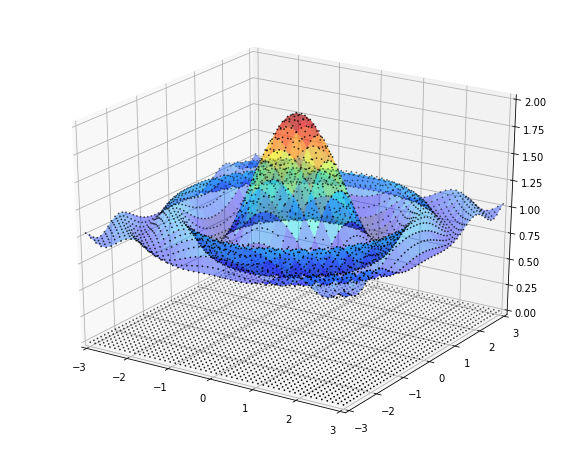

In [54]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

gridsize = 50
gmin, gmax = -3, 3
xgrid = np.linspace(gmin, gmax, gridsize)
ygrid = xgrid
x, y = np.meshgrid(xgrid, ygrid)

# === plot value function === #
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                f(x, y),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.4,
                linewidth=0.05)


ax.scatter(x, y, c='k', s=0.6)

ax.scatter(x, y, f(x, y), c='k', s=0.6)

ax.view_init(25, -57)
ax.set_zlim(-0, 2.0)
ax.set_xlim(gmin, gmax)
ax.set_ylim(gmin, gmax)

plt.show()


#### Vectorized code

Let's see how fast the vectorized approach runs.

In [55]:
grid = np.linspace(-3, 3, 10_000)

In [56]:
x, y = np.meshgrid(grid, grid)

In [57]:
%%time 
np.max(f(x, y))


CPU times: user 2.93 s, sys: 157 ms, total: 3.09 s
Wall time: 3.09 s


1.999999819964011

#### JITTed code

A jitted version

In [58]:
@jit
def compute_max():
    m = -np.inf
    for x in grid:
        for y in grid:
            z = np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1
            if z > m:
                m = z
    return m

In [59]:
%%time

compute_max()


CPU times: user 2.26 s, sys: 3.33 ms, total: 2.26 s
Wall time: 2.27 s


1.999999819964011

In [60]:
%%time

compute_max()


CPU times: user 2.12 s, sys: 6.67 ms, total: 2.12 s
Wall time: 2.12 s


1.999999819964011

This is faster than the vectorized code.  In both cases we have highly specialized and optimized machine code.  However, the vectorized code is much more memory intensive because it generates a lot of intermediate arrays, all of which are large.  

That's why it's relatively slow.  This is a common problem with vectorized code in computationally intensive settings.

#### JITTed, parallelized code: @vectorize

For this particular example, Numba plus vectorization with automatic parallization is even faster:

In [61]:
@vectorize('float64(float64, float64)', target='parallel')
def f_par(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

In [62]:
x, y = np.meshgrid(grid, grid)

np.max(f_par(x, y))

1.999999819964011

In [63]:
%%time

np.max(f_par(x, y))

CPU times: user 3.52 s, sys: 60 ms, total: 3.58 s
Wall time: 509 ms


1.999999819964011

### Summary

We just scratched the surface of Numba goodness.  For further reading see:
    
* [the docs](http://numba.pydata.org/)
* [this overview](http://matthewrocklin.com/blog/work/2018/01/30/the-case-for-numba)